После установки пакетов нужно перезагрузить среду

In [1]:
!pip install -U catboost pymatgen jarvis-tools dgl alignn dgl-cu111 matplotlib importlib pytorch-lightning -qqq

ERROR: Could not find a version that satisfies the requirement dgl-cu111 (from versions: none)
ERROR: No matching distribution found for dgl-cu111


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/IDAO

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pymatgen.core as mg
from pymatgen.io.jarvis import JarvisAtomsAdaptor
import dgl
from jarvis.core.atoms import Atoms
from jarvis.core.graphs import Graph, StructureDataset
from alignn.models.alignn import ALIGNN
from catboost import CatBoostRegressor

Using backend: pytorch


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def read_graph(file: str):
    """Read graph and convert to DGLGraph."""

    with open(file, "r") as f:
        d = json.load(f)
    structure = mg.Structure.from_dict(d)
    structure = JarvisAtomsAdaptor.get_atoms(structure)

    return Graph.atom_dgl_multigraph(
        structure,
        cutoff=8.0,
        atom_features="cgcnn",
        max_neighbors=12,
        compute_line_graph=True,
        use_canonize=False,
    )

# Данные

In [ ]:
TARGETS = "datasets/dichalcogenides_public/targets.csv"
TRAIN_DATA_DIR = "datasets/dichalcogenides_public/structures/"
TEST_DATA_DIR = "datasets/dichalcogenides_private/structures/"

In [ ]:
df = pd.read_csv(TARGETS)
df.head()

,_id,band_gap
0,6141cf0f51c1cbd9654b8870,1.0843
1,6141cf1051c1cbd9654b8872,1.1102
2,6141cf11cc0e69a0cf28ab35,1.1484
3,6141cf11b842c2e72e2f2d48,1.8068
4,6141cf11ae4fb853db2e3f14,0.3600


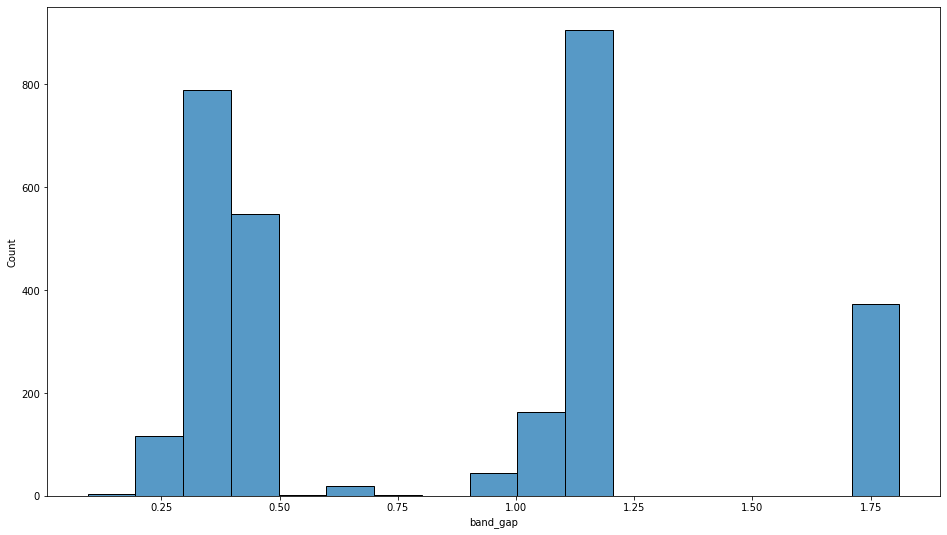

In [ ]:
plt.figure(figsize=(16, 9))
sns.histplot(df["band_gap"])

plt.show()

In [ ]:
class GraphDataset(Dataset):
    def __init__(self, ids: np.ndarray, targets=None, folder=TRAIN_DATA_DIR):
        super().__init__()
        self.ids = ids
        self.targets = torch.from_numpy(targets).float() if targets is not None else None
        self.folder = folder
        self.cache = dict()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index: int):
        if index in self.cache:
            return self.cache[index]

        file = f"{self.folder}/{self.ids[index]}.json"

        graphs = read_graph(file)

        if self.targets is None:
            self.cache[index] = (*graphs, torch.tensor([0.0]))
            return self.cache[index]

        self.cache[index] = (*graphs, self.targets[index])

        return self.cache[index]

In [ ]:
ids = df["_id"].values
targets = df["band_gap"].values
targets = targets.astype(np.float32)
dataset = GraphDataset(ids, targets, TRAIN_DATA_DIR)

In [ ]:
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(
    dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
BATCH_SIZE = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=StructureDataset.collate_line_graph, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=StructureDataset.collate_line_graph, num_workers=2)

# Model

In [ ]:
def energy_within_threshold(y, y_pred, eps=0.02):
    return (torch.abs(y - y_pred) < eps).float().mean()

a = torch.tensor([1., 2., 3.])
b = torch.tensor([1.01, 2.03, 3.0005])

assert energy_within_threshold(a, b, 0.02) == 2 / 3

In [ ]:
class BandGapPredictor(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.predictor = ALIGNN()

    def forward(self, x):
        return self.predictor(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        g, lg, y = train_batch
        y_pred = self.predictor((g, lg))
        loss = F.mse_loss(y, y_pred)
        self.log("train_loss", loss, batch_size=len(y))
        return loss

    def validation_step(self, val_batch, batch_idx):
        g, lg, y = val_batch
        y_pred = self.predictor((g, lg))
        loss = F.mse_loss(y, y_pred)
        ewt = energy_within_threshold(y, y_pred)
        self.log("val_loss", loss, batch_size=len(y))
        self.log("ewt", ewt, batch_size=len(y))

In [ ]:
sum(p.numel() for p in BandGapPredictor().parameters())

4026753

In [ ]:
model = BandGapPredictor.load_from_checkpoint("./checkpoints/bandgap-epoch=01-ewt=0.86.ckpt")

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="ewt",
    dirpath="./checkpoints/",
    filename="bandgap-{epoch:02d}-{ewt:.2f}",
    save_top_k=3,
    mode="max",
)

trainer = pl.Trainer(gpus=1, 
                     callbacks=[checkpoint_callback],
                     max_epochs=6, precision=32,
                     accumulate_grad_batches=8,
                     gradient_clip_val=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type   | Params
-------------------------------------
0 | predictor | ALIGNN | 4.0 M 
-------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.107    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/drive/MyDrive/Work/IDAO/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Submission

In [ ]:
test_files = [str(file) for file in Path(TEST_DATA_DIR).glob("*.json")]
print("Размер тестовой выборки:", len(test_files))

Размер тестовой выборки: 2967


In [ ]:
test_ids = np.array([Path(file).stem for file in test_files])
test_ids[:10]

array(['61422d7dbaaf234b35290650', '61422d8c31cf3ef3d4a9f394',
       '61422cad4e27a1844a5f068a', '61422ccd31cf3ef3d4a9f390',
       '61422c54baaf234b3529064c', '614229f43ac25c70a5c6caff',
       '61422ac43ac25c70a5c6cb03', '61422c564e27a1844a5f0686',
       '61422b373ac25c70a5c6cb05', '61422a1831cf3ef3d4a9f37e'],
      dtype='<U24')

In [ ]:
test_dataset = GraphDataset(test_ids, folder=TEST_DATA_DIR)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,
                         collate_fn=StructureDataset.collate_line_graph, num_workers=1)

In [ ]:
checkpoint_path = "./checkpoints/bandgap-epoch=01-ewt=0.86.ckpt"
model = BandGapPredictor.load_from_checkpoint(checkpoint_path).to(device)

In [ ]:
predictions = []
model.eval()
with torch.no_grad():
    for g1, g2, _ in tqdm(test_loader):
        g1 = g1.to(device)
        g2 = g2.to(device)
        y_pred = model((g1, g2))
        predictions += y_pred.tolist()

  0%|          | 0/742 [00:00<?, ?it/s]

In [ ]:
pred_right = predictions[-len(test_ids):]

In [ ]:
submit = pd.DataFrame(data={"id": test_ids, "predictions": pred_right})
submit.to_csv("submission.csv", index=False)

# Stacking

In [ ]:
checkpoints_to_stack = [
    "checkpoints/bandgap-epoch=01-ewt=0.86.ckpt",
    "checkpoints/bandgap-epoch=04-ewt=0.85.ckpt",
    "checkpoints/bandgap-epoch=05-ewt=0.83.ckpt",
    "checkpoints/bandgap-epoch=00-ewt=0.83.ckpt",
]

## Feature creating

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=StructureDataset.collate_line_graph, num_workers=1)

In [ ]:
data = {"target": []}

In [ ]:
for _, _, target in tqdm(train_loader):
    if target.dim() == 0:
        data["target"].append(target.item())
    else:
        data["target"] += target.tolist()

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():


  0%|          | 0/594 [00:00<?, ?it/s]

  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())


In [ ]:
pd.Series(data["target"]).to_csv("train_targets.csv")

In [ ]:
def get_features(data, loader):
    for idx, checkpoint in enumerate(tqdm(checkpoints_to_stack)):
        model = BandGapPredictor.load_from_checkpoint(checkpoint).to(device)
        predictions = []
        model.eval()
        with torch.no_grad():
            for g1, g2, target in tqdm(loader):
                g1 = g1.to(device)
                g2 = g2.to(device)
                y_pred = model((g1, g2))
                if y_pred.dim() == 0:
                    predictions.append(y_pred.item())
                else:
                    predictions += y_pred.tolist()
        data[f"Model{idx}"] = predictions

In [ ]:
get_features(data, train_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/594 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/594 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/594 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.head()

,target,Model0,Model1,Model2,Model3
0,0.4111,0.394149,0.392275,0.417868,0.389002
1,0.3951,0.386615,0.380413,0.402591,0.386619
2,0.4181,0.385392,0.384398,0.396416,0.381351
3,1.8072,1.815851,1.819433,1.801288,1.827844
4,0.3477,0.327618,0.327378,0.352771,0.338940


In [ ]:
df.to_csv("train_data.csv", index=False)

In [ ]:
regressor = CatBoostRegressor()

In [ ]:
X_train = df.drop(columns=["target"]).values

In [ ]:
y_train = df["target"].values

In [ ]:
regressor.fit(X_train, y_train)

Learning rate set to 0.046933
0:	learn: 0.4843199	total: 56.1ms	remaining: 56.1s
1:	learn: 0.4621345	total: 59.1ms	remaining: 29.5s
2:	learn: 0.4411437	total: 64.3ms	remaining: 21.4s
3:	learn: 0.4207982	total: 71.1ms	remaining: 17.7s
4:	learn: 0.4014723	total: 75.4ms	remaining: 15s
5:	learn: 0.3832045	total: 80.4ms	remaining: 13.3s
6:	learn: 0.3656687	total: 85.7ms	remaining: 12.2s
7:	learn: 0.3494483	total: 91.4ms	remaining: 11.3s
8:	learn: 0.3337287	total: 96ms	remaining: 10.6s
9:	learn: 0.3189164	total: 106ms	remaining: 10.5s
10:	learn: 0.3046267	total: 111ms	remaining: 9.94s
11:	learn: 0.2906383	total: 116ms	remaining: 9.53s
12:	learn: 0.2775229	total: 121ms	remaining: 9.18s
13:	learn: 0.2649485	total: 126ms	remaining: 8.89s
14:	learn: 0.2530451	total: 131ms	remaining: 8.62s
15:	learn: 0.2420119	total: 139ms	remaining: 8.54s
16:	learn: 0.2313723	total: 142ms	remaining: 8.19s
17:	learn: 0.2213770	total: 147ms	remaining: 8.03s
18:	learn: 0.2114063	total: 152ms	remaining: 7.85s
19:	le

In [ ]:
test_data = dict()

In [ ]:
get_features(test_data, test_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
  File "/usr/local/lib/pyth

  0%|          | 0/742 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutd

  0%|          | 0/742 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutd

  0%|          | 0/742 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  r = torch.tensor(r).type(torch.get_default_dtype())
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1f50b65f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutd

In [ ]:
test_df = pd.DataFrame(test_data)

In [ ]:
test_df.head()

,Model0,Model1,Model2,Model3
0,1.099309,1.097491,1.109785,1.097965
1,0.358465,0.358037,0.368747,0.357277
2,1.142966,1.140793,1.159985,1.146867
3,0.414143,0.410976,0.429847,0.414484
4,1.106187,1.100921,1.112051,1.106959


In [ ]:
test_df.to_csv("test_data.csv", index=False)

In [ ]:
X_test = test_df.values

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
submit_df = pd.DataFrame(data={
    "id": test_ids,
    "predictions": y_pred,
})

In [ ]:
submit_df.head()

,id,predictions
0,61422d7dbaaf234b35290650,1.103085
1,61422d8c31cf3ef3d4a9f394,0.355508
2,61422cad4e27a1844a5f068a,1.145741
3,61422ccd31cf3ef3d4a9f390,0.417158
4,61422c54baaf234b3529064c,1.105755


In [ ]:
submit_df.to_csv("submission.csv", index=False)